# What's good in Montreal?

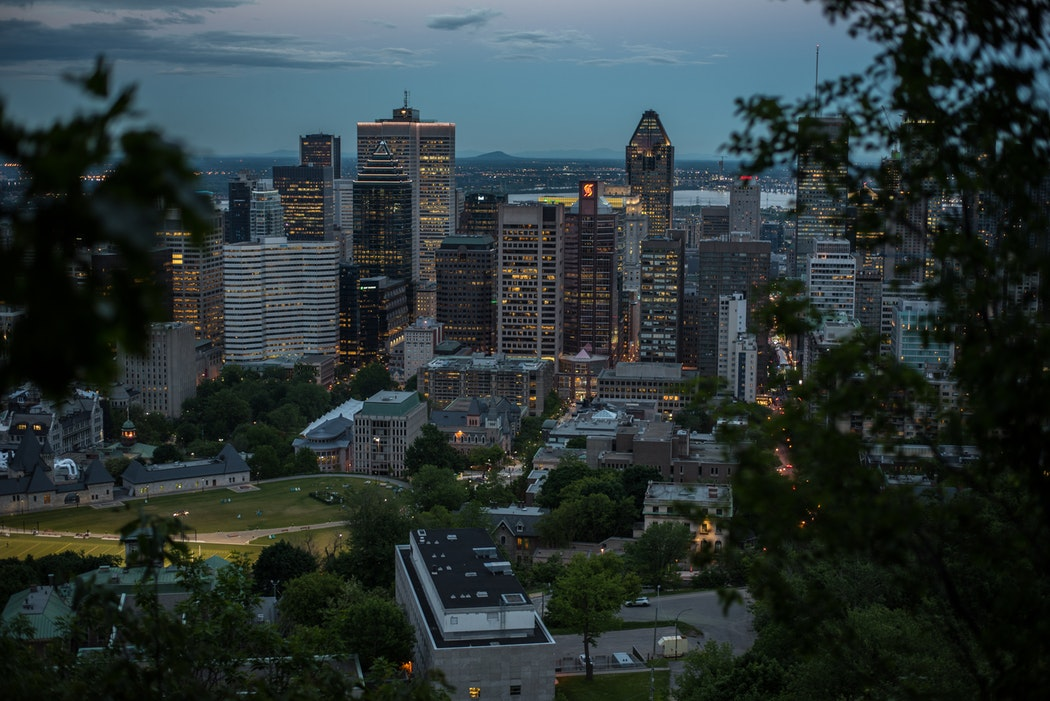

In [2]:
from IPython.display import Image
Image("cover-openstreetmap.jpeg")

## Introduction

In this project, we will explore OpenStreetMap Montreal Data. The main goals of this project are on the one hand process the OSM file, inspect and clean up the data while documenting any problems met, and on the other hand, save the cleaned up data into an SQLite database, use diffent SQL queries, and finally explore and visualize the data. <br/>
The data can be found [here](https://mapzen.com/data/metro-extracts/metro/montreal_canada/).

## OpenStreetMap data structure

We have 3 main classes:
* Node: it consists of a single point in space defined by its latitude, longitude and node id.
* Way: is an ordered list of nodes 
* Relation: consists of one or more tags and also an ordered list of one or more nodes, ways and/or relations

## I - Wrangling phase

### General Inspection and problems encountered :

In [1]:
import xml.etree.cElementTree as ET
import os
import re
s = os.path.getsize('montreal_canada.osm')
'File size: ' + str(round(float(s)/1000000)) + ' MB'

'File size: 875 MB'

Given the relatively big size of this file, let's create a sample. That will allow us to test our code and explore the data faster.

In [7]:
OSM_FILE = "montreal_canada.osm"
SAMPLE_FILE = "sample.osm"

k = 10

def get_element(osm_file, tags=('node', 'way', 'relation')):

    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write(b'<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write(b'<osm>\n  ')


    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write(b'</osm>')

Let's familiarize ourselves with the data:

In [4]:
def count_tags(filename):
    dic = {}
    for elem in ET.iterparse(filename, events = ('start',)):
        try:
            dic[elem[1].tag] += 1
        except:
            dic[elem[1].tag] = 1
    return dic

In [5]:
nbr_tags = count_tags("sample.osm")
nbr_tags

{'osm': 1,
 'node': 368871,
 'tag': 300341,
 'way': 50765,
 'nd': 439845,
 'relation': 1060,
 'member': 5789}

So the function count_tags works well. after a quick search on google, we find that 'nd' (short for node) are subtags of ways and members subtags of relations. tags are subtags of both nodes and ways.

### Street names inspection

Let's first look at the list of streets in this sample to get a general sense of what we are working with as well as any potential issues

In [6]:
i = 0
for elem in ET.iterparse("sample.osm"):
    if elem[1].tag == 'tag':
        if elem[1].attrib['k'] == 'addr:street' and i<20:
            print(elem[1].attrib['v'])
            i += 1
# Although the entire list was used for the analysis, it would be too lengthy to print it out entirely 

Boulevard Taschereau
Rue Sainte-Catherine Ouest
Rue Beaubien Est
Avenue Gatineau
Boulevard Édouard-Montpetit
Boulevard Édouard-Montpetit
Avenue Gatineau
Rue Fendall
Avenue Lacombe
Avenue Decelles
Rue McKenna
Place Tisserand
Rue Saint-Urbain
Rue Lambert-Closse
Avenue Hawarden
Avenue Atwater
Rue du Fort
Rue Baile
Rue Tupper
Rue Saint-Marc


Right away, we can notice a few issues:
- Montreal is a bilingual city so the streets can have either french or engish names
- Bus routes are also present in this list
- some streets are numbered avenues with no name (ex. 8e Avenue which stands for 8th Avenue)


However, we can see some patterns in the names:
- for french names = (street type + street name) or (avenue number + Avenue)
- for english names = (street name + street type + optional east/west/north/south orientation)
- bus routes


In [7]:
# Expected Street types for both french and english
expected_fr = ['Rue','Chemin','Croissant','Avenue','Boulevard','Montée','Côte','Allée','Place','Carré','Rang']
expected_en = ['Street','Avenue','Boulevard','Road','Drive','Crescent','Place']

In [8]:
def is_french(name):
    parts = name.split()
    ave_check = re.match(r'^[0-9]+e$',parts[0]) != None
    if (parts[0] in expected_fr) or ave_check: return True
    else: return False

def is_english(name):
    parts = name.split()
    if parts[-1] in ['East','West','South','North']:
        if parts[-2] in expected_en: return True
        else: return False
    else:
        if parts[-1] in expected_en: return True
        else: return False

In [9]:
problem_streets = []
dict = {'french':0,'english':0,'other':0}
for event,elem in ET.iterparse("sample.osm",events = ('start',)):
    if elem.tag == 'tag':
        if elem.attrib['k'] == 'addr:street':
            if is_french(elem.attrib['v']): dict['french'] += 1
            elif is_english(elem.attrib['v']): dict['english'] += 1
            else: 
                dict['other'] += 1
                problem_streets.append(elem.attrib['v'])

In [10]:
print(dict)

{'french': 37281, 'english': 1118, 'other': 1354}


In [11]:
# Here we inspect the addresses that end up in 'other'

for i in problem_streets[0:20]:
   print(i)

# Although the entire list was used for the analysis, it would be too lengthy to print it out entirely

du Collège
Shaghenessy
Sainte-Catherine O
County Road 2
Richmond Court
Road Mary Adams
Road Snye School
Route 132
County Road 2
Salem Lane
Road Whoville
County Road 27
County Road 27
County Road 2
County Road 27
County Road 27
County Road 27
County Road 2
County Road 2
St. Francis Lane


We see that we have a lot more streets in the 'other' category than expected. the issues now seem to be:
- some street do not contain a street type
- steets that are numbered but not named were not accounted for in english streets
- some street types were not accounted for such as Court or Lane
- inveted format for english streets
- french accents don't seem to be processed properly (encoding problem)
- lower case or abbreviated street types
- highways, county roads, concession roads and bus routes

In [12]:
expected_fr = ['Ruelle','Descente','Rue','Chemin','Croissant','Avenue','Boulevard','Montée','Côte','Allée','Place','Carré', 'Route',
               'Rang','Terrasse','Cercle','Impasse','Promenade','Cours','Domaine','Traverse','Plateau','Voie','Circuit','Parc']
expected_en = ['Street','Avenue','Boulevard','Road','Drive','Crescent','Place','Court','Lane','Circle','Park','Square','Terrace',
              'Sideroad']

def is_french(name):
    parts = name.split()
    ave_check = (re.match(r'^[0-9]+e$',parts[0]) != None) or (re.match(r'^[0-9]+ere$',parts[0]) != None)
    route_check = (re.match(r'^Route',parts[0]) != None) and (re.match(r'[0-9]',parts[-1]) != None)
    rang_check = (re.match(r'^Grand\srang',name) != None) or (re.match(r'^Petit\srang',name) != None)
    if (parts[0] in expected_fr) or ave_check or route_check or rang_check: return True
    else: return False

def is_english(name):
    parts = name.split()
    ave_check = re.match(r'^[0-9]$',parts[0]) != None
    if parts[-1] in ['East','West','South','North']:
        if parts[-2] in expected_en : return True
        else: return False
    else:
        if parts[-1] in expected_en: return True
        else: return False
        
def is_invert_english(name):              # only use after checking both is_french and is_english
    parts = name.split()
    if parts[0] in expected_en: return True
    else: return False

def bus_highw(name):
    possibilities = ['County Road','Concession Road','Concession', 'Highway','Autoroute','Old Highway','State Route','Route 138A']
    for p in possibilities:
        if name.find(p) != -1: return True
    condi = re.match(r'^Route\s[0-9]+$',name) != None
    if condi: return True
    else: return False

In [13]:
problem_streets = []
inverted_en = []
dict = {'french':0,'english':0,'inverted_en':0,'highways&buses':0,'other':0}
for event,elem in ET.iterparse("sample.osm",events = ('start',)):
    if elem.tag == 'tag':
        if elem.attrib['k'] == 'addr:street':
            if is_french(elem.attrib['v']): dict['french'] += 1
            elif is_english(elem.attrib['v']): dict['english'] += 1
            elif is_invert_english(elem.attrib['v']):
                dict['inverted_en'] += 1
                inverted_en.append(elem.attrib['v'])
            elif bus_highw(elem.attrib['v']): dict['highways&buses'] += 1
            else: 
                dict['other'] += 1
                problem_streets.append(elem.attrib['v'])

In [14]:
print(dict)

{'french': 38099, 'english': 1144, 'inverted_en': 75, 'highways&buses': 219, 'other': 216}


In [15]:
# Again re-checking all the addresses that end up in 'other'

for i in problem_streets[:20]:
   print(i)

# Although the entire list was used for the analysis, it would be too lengthy to print it out entirely

du Collège
Shaghenessy
Sainte-Catherine O
Petit Rang
Petit Rang
Petit-10e Rang
Haut-du-Petit-Rang-St-François
Petit-11e Rang
Haut-du-Petit-Rang-St-François
3969 Wellington
Grande Allée
Grande Allée
Grande Allée
Grande Côte Ouest
Grande Côte Est
Grande Côte Est
Grande Côte Est
Grande Côte Est
La Grande-Caroline
La Grande-Caroline


We are left with 216 entries in 'Other'containing mostly street names without types, 2 erroneous entries, a few lower cases and abreviated street types, some Boroughs, and some unidentifed entries.

We will solve 3 problems here:
- change lowercase and abreviated street names to meet the is_french or is_english function requirement
- reorder the inverted english street names.
- capitalize the street names that don't belong in either french or english street names

In [16]:
mapping = {'chemin':'Chemin','ch.':'Chemin','Ch.':'Chemin',
           'Ave':'Avenue','ave':'Avenue','Ave.':'Avenue','ave.':'Avenue','avenue':'Avenue',
           'Boul':'Boulevard','boul':'Boulevard','boul.':'Boulevard','Boul.':'Boulevard','blvd':'Boulevard','blvd.':'Boulevard',
           'boulvard':'Boulevard','boulevard':'Boulevard','Blvd':'Boulevard','Blvd.':'Boulevard','Boulvard':'Boulevard',
           'rue':'Rue','Rus':'Rue','Hwy':'Highway','cote':'Côte','Cote':'Côte','montee':'Montée','place':'Place',
          'dr':'Drive','street':'Street','Ruq':'Rue','Rte':'Route','rte':'Route'}

#========================================================================================

def update_fr(name, mapping):
    if type(name) == 'bytes': name = name.decode('utf8')
    p = name.split()
    if re.match(r'^[0-9]+,',name) != None or re.match(r'^[0-9]+\s',name) != None:
        p = p[1:]
    for key,val in mapping.items():
        if p[0] == key:
            p[0] = val
            return ' '.join(p)

def is_fr_lowercase(name,mapping):
    p = name.split()
    return (p[0] in mapping.keys()) or re.match(r'^[0-9]+,',name) != None

#====================================================================================

def update_en(name, mapping):
    p = name.split()
    if re.match(r'^[0-9]+,',name) != None or re.match(r'^[0-9]+\s',name) != None:
        p = p[1:]
    for key,val in mapping.items():
        if p[-1] == key:
            p[-1] = val
            return ' '.join(p)

def is_en_lowercase(name,mapping):
    p = name.split()
    if p[-1] in ['East','West','South','North']:
        return (p[-2] in mapping.keys())
    else:
        return (p[-1] in mapping.keys())



In [17]:
for i in problem_streets:                                # just to test if the function works properly
    if is_fr_lowercase(i,mapping):
        print(i + " ===> " + update_fr(i,mapping))
    if is_en_lowercase(i,mapping):
        print(i + " ===> " + update_en(i,mapping))

St-Charles blvd ===> St-Charles Boulevard
rue Molson ===> Rue Molson
boulevard Cavendish ===> Boulevard Cavendish
540, rue d'Avaugour ===> Rue d'Avaugour
boulevard Leduc ===> Boulevard Leduc
Boul. des Prairies ===> Boulevard des Prairies
avenue Lajoie ===> Avenue Lajoie
avenue Saint-Denis ===> Avenue Saint-Denis
rue Shanonn ===> Rue Shanonn
boulevard St-Jean ===> Boulevard St-Jean
avenue du Mont-Royal Est ===> Avenue du Mont-Royal Est
chemin Hudson ===> Chemin Hudson
Papineau Ave. ===> Papineau Avenue
boul. Des Sources ===> Boulevard Des Sources
boulevard St-Jean ===> Boulevard St-Jean
rue Ottawa ===> Rue Ottawa
avenue Armand-Chaput ===> Avenue Armand-Chaput
Boulvard Grignon ===> Boulevard Grignon
Boul St-Martin ===> Boulevard St-Martin
chemin de la Côte-Sainte-Catherine ===> Chemin de la Côte-Sainte-Catherine
chemin de la Côte Ste-Catherine ===> Chemin de la Côte Ste-Catherine


So the function works perfectly. Let's now see how we can fix the inverted english street names:

In [18]:
def order_en(name):
    p = name.split()
    t = t = p[1:]+p[:1]
    return ' '.join(t)

In [19]:
i = 0
for street in inverted_en:
    if i < 10:
        print(street + ' ===> ' + order_en(street))
        i += 1

Road Mary Adams ===> Mary Adams Road
Road Snye School ===> Snye School Road
Road Whoville ===> Whoville Road
Street Saint-Regis ===> Saint-Regis Street
Street Willow ===> Willow Street
Sideroad Nixon ===> Nixon Sideroad
Road Pine ===> Pine Road
Road Pine ===> Pine Road
Drive Lakeshore ===> Lakeshore Drive
Drive Lakeshore ===> Lakeshore Drive


"Order_en" function works well. Lastly, we will add one screening for erroneous entries and an improvement function for the rest:

In [20]:
def error_check(name):                       # to be used once all the other checks have been done
    e1 = re.match(r'[0-9]+$',name) != None or re.match(r'^Voie$',name) or re.match(r'^[0-9]+\s[a-zA-z]ue$',name) != None
    e2 = re.match(r'[A-Za-z]+\-$',name) != None or re.match(r'[a-zA-Z0-9]+\s[/]\s[a-zA-Z0-9]+',name) != None
    e3 = re.match(r'^http',name) != None or re.match(r'^Montréal\-Toronto$',name) != None or re.match(r'^Canada$',name) != None
    e4 = re.match(r'[a-zA-Z0-9]+\sand\s[a-zA-Z0-9]+',name) != None or re.match(r'[a-zA-Z0-9\s]+\set\s[0-9]+',name) != None
    e5 = name.encode('utf8') == 'Sucrerie' or name.encode('utf8') == 'Plage' or name.encode('utf8') == 'Lake'
    return e1 or e2 or e3 or e4 or e5

In [21]:
error_check('Ste-'),error_check('221')  # Both types of errors encountered in the sample

(True, True)

In [22]:
def improv_other(name):
    p = name.split()
    if name == 'A-25': return 'Autoroute 25'
    elif name == 'RTE-138': return 'Route 138'
    elif name.encode('utf8') == 'De Maisonneuve Est, 17e étage':
        t = name.split(',')
        return ' '.join(t[:-1])
    elif re.match(r'^[0-9]+\s',name) != None:
        if is_fr_lowercase(' '.join(p[1:]),mapping): return update_fr(' '.join(p[1:]),mapping)
        elif is_en_lowercase(' '.join(p[1:]),mapping): return update_en(' '.join(p[1:]),mapping)
        else: return ' '.join(p[1:]).title()
    else: return name.title()

Let's put it all together now. Here's a summary of the format that will be used to store the data in a dataset:
- check if the street name is in french using "is_french" function. If yes, store data
- check if the street name is in english using "is_english" function. If yes, store data
- check if the street name is in english but inverted using "is_invert_english". If yes, fix it using "order_en" then store data
- check if the street name is a highway, bus route, or other special roads using "bus_highw".i If yes, store data
- check if the street name is in french or english but lower case or abreviated using "is_fr_lowercase" and "is_en_lowercase". If yes, fix it using "update_fr" and "update_en" then store data
- check if the street name is an erroneous entry using "error_check". If yes, skip entry
- lastly if none of these cases apply (meaning its an incomplete street name but still valid), we use "improv_other" then store data


Running this model on the whole .osm file, we add any other abbreviations or error to our functions. Let's also create one all-in function to audit and fix steet names:

In [23]:
def audit_fix_streets(street_name):
    if is_french(street_name): return street_name
    elif is_english(street_name): return street_name
    elif is_invert_english(street_name): return order_en(street_name)
    elif bus_highw(street_name): return street_name
    elif is_fr_lowercase(street_name,mapping): return update_fr(street_name,mapping)
    elif is_en_lowercase(street_name,mapping): return update_en(street_name,mapping)
    elif error_check(street_name): return None
    else: return improv_other(street_name)

### Postal Code inspection

In [24]:
# Was used to check all the errors in postal codes
# Although the entire list was used for the analysis, it would be too lengthy to print it out entirely


#for elem in ET.iterparse("sample.osm"):
#    if elem[1].tag == 'tag':
#        if elem[1].attrib['k'] == 'addr:postcode':
#            print(elem[1].attrib['v'])

The correct format for a postal code in Montreal is "LNL NLN" where L = Letter and N = Number.
Here, we can see 4 issues:
- missing space
- incomplete code
- 2 entries in same field  ==> will be left unchanged
- wrong entry (ex. 'CA')

In [25]:
def audit_fix_zipcode(zipp):
    if type(zipp) == 'bytes': zipp = zipp.decode('utf8')       # to account for encoding issues
    if re.match(r'^Q[cC]\s.*',zipp) != None:                   # to account for zipcodes that start with 'QC' (short for Quebec)
        y = zipp.split()
        zipp = ' '.join(y[1:])
    
    if re.match(r'^[a-zA-Z][0-9][a-zA-Z]\s[0-9][a-zA-Z][0-9]',zipp) != None: return zipp.upper().rstrip()
    elif re.match(r'^[a-zA-Z][0-9][a-zA-Z][\-][0-9][a-zA-Z][0-9]',zipp) != None: 
        u = zipp.split('-')
        return ' '.join(u).upper().rstrip()
    elif re.match(r'^[a-zA-Z][0-9][a-zA-Z]\s+[0-9][a-zA-Z][0-9]',zipp) != None:
        t = zipp.split('  ')
        return t[0].upper()+' '+t[1].upper()
    elif re.match(r'^[a-zA-Z][0-9][a-zA-Z][0-9][a-zA-Z][0-9]',zipp) != None: return (zipp[:3]+' '+zipp[3:]).upper().rstrip()
    elif zipp == 'KOB 1R0': return 'K0B 1R0'          #typing mistake
    elif zipp == 'H8S 1R!': return 'H8S 1R1'          #typing mistake
    elif zipp ==  ' H4P 1L9': return 'H4P 1L9'        #typing mistake
    elif zipp == 'H3G 29R': return 'H3G 2R9'          #typing mistake
    elif zipp == 'HR9 1C4': return 'H9R 1C4'          #typing mistake
    else: return None

In [26]:
u = 0
for event,elem in ET.iterparse("montreal_canada.osm",events = ('start',)):
    if u <= 15:
        if elem.tag == 'tag':
            if elem.attrib['k'] == 'addr:postcode':
                print(audit_fix_zipcode(elem.attrib['v']))
                u += 1
    else: break

J4X 1C3
J4Y 1A1
J4X 1C2
H9J 2W2
H3B 4W3
H2T 2R9
H3G 2H1
H3H 1M1
H2V 4G9
H2V 4G3
H9P 1B8
H9R 5A5
J5R 3X8
J4W 1M9
J4Y 1V9
H2G 1N2


The code seems to function well. Now that we have audit_fix_zipcode and audit_fix_streets to clean up zipcodes and street names, let's jump ahead to exporting the data to a database.

## II - Storing the data into a database

Let's turn our attention now to the storage of this data. We will use the format from the problem set. So first let's put the data into csv files. Once that is done, we can easily import it into an database.

In [10]:
import csv
import codecs

In [11]:
LOWER_COLON = re.compile(r'^.+:.+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

#----------------------------------------------------------------------------------

NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
TAGS_FIELDS = ['id','key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

In [29]:
def global_acq(elem,kind):                          # short for global acquisition
    dict = {}
    if kind == 'node':
        for f in NODE_FIELDS:
            dict[f] = elem.attrib[f]
    if kind == 'way':
        for f in WAY_FIELDS:
            dict[f] = elem.attrib[f]
    
    return dict

#==========================================================================

def sort_columns(entry):
    if LOWER_COLON.match(entry.attrib['k']) != None:
        p = entry.attrib['k'].split(':')
        return p[0],':'.join(p[1:])                                 # returns type,key
    else: return 'regular', entry.attrib['k']

In [12]:
nodes = []               
nodes_tags = []
ways = []
ways_tags = []
ways_nodes = []

In [ ]:
for event,elem in ET.iterparse("montreal_canada.osm",events = ('start',)):
    if elem.tag == 'node':
        nodes.append(global_acq(elem,'node'))
        dict_node = {}
        for subtag in elem:
            if PROBLEMCHARS.match(subtag.attrib['k']) != None: continue
            t,k = sort_columns(subtag)
            dict_node['id'] = elem.attrib['id']
            dict_node['key'] = k
            dict_node['type'] = t
            if subtag.attrib['k'] == 'addr:street': dict_node['value'] = audit_fix_streets(subtag.attrib['v'])
            elif subtag.attrib['k'] == 'addr:postcode': dict_node['value'] = audit_fix_zipcode(subtag.attrib['v']) 
            else: dict_node['value'] = subtag.attrib['v']
            
        if bool(dict_node):
            nodes_tags.append(dict_node)
    
    if elem.tag == 'way':
        ways.append(global_acq(elem,'way'))
        dict_nd = {}
        dict_way = {}
        c = 0
        for subtag in elem:
            if subtag.tag == 'tag':
                if PROBLEMCHARS.match(subtag.attrib['k']) != None: continue
                t,k = sort_columns(subtag)
                dict_way['id'] = elem.attrib['id']
                dict_way['key'] = k
                dict_way['type'] = t
                if subtag.attrib['k'] == 'addr:street': dict_way['value'] = audit_fix_streets(subtag.attrib['v'])
                elif subtag.attrib['k'] == 'addr:postcode': dict_way['value'] = audit_fix_zipcode(subtag.attrib['v']) 
                else: dict_way['value'] = subtag.attrib['v']                
                
            if bool(dict_way):
                ways_tags.append(dict_way)
            
            if subtag.tag == 'nd':
                dict_nd['id'] = elem.attrib['id']
                dict_nd['node_id'] = subtag.attrib['ref']
                dict_nd['position'] = c
                c += 1
            if bool(dict_nd):
                ways_nodes.append(dict_nd)
    else: continue

So we now have all the data in the appropriate format saved as well as corrected in case it was a street name or postcode. Let's save them in csv files:

In [61]:
class UnicodeDictWriter(csv.DictWriter, object):

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

In [13]:
NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

In [14]:
files_list   = [NODES_PATH,NODE_TAGS_PATH,WAYS_PATH,WAY_NODES_PATH,WAY_TAGS_PATH]
data_list    = [nodes,nodes_tags,ways,ways_nodes,ways_tags]
headers_list = [NODE_FIELDS,TAGS_FIELDS,WAY_FIELDS,WAY_NODES_FIELDS,TAGS_FIELDS]

In [34]:
for i in range(0,5):
    with codecs.open(files_list[i], 'w') as csvfile:
        writer = UnicodeDictWriter(csvfile,headers_list[i])
        writer.writeheader()
        for d in data_list[i]:
            writer.writerow(d)

### File sizes

In [15]:
for f in files_list:
    s = os.path.getsize(f)
    print(f + '\t\t'+ str(round(float(s)/1000000)) + ' MB')

nodes.csv		313 MB
nodes_tags.csv		16 MB
ways.csv		13 MB
ways_nodes.csv		66 MB
ways_tags.csv		25 MB


So everything seems to be working properly. We can see that files do exist (were created after running previous code) and sizes are reasonable. Let's procede to the final step, putting the data in a database:

In [16]:
tables_creation = '''
CREATE TABLE nodes (
    id INTEGER PRIMARY KEY NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
);

CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id)
);

CREATE TABLE ways (
    id INTEGER PRIMARY KEY NOT NULL,
    user TEXT,
    uid INTEGER,
    version TEXT,
    changeset INTEGER,
    timestamp TEXT
);

CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways(id)
);

CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways(id),
    FOREIGN KEY (node_id) REFERENCES nodes(id)
)'''

In [17]:
import sqlite3
import pandas as pd

In [18]:
# making a list of table names to use in a loop
tablenames = ['nodes','nodes_tags','ways','ways_nodes','ways_tags']

In [23]:
conn = sqlite3.connect('mtl.db')
conn.text_factory = str
cur = conn.cursor()
# cur.executescript(tables_creation)               # creating the tables

In [20]:
for i in range(0,5):
    df = pd.read_csv(files_list[i])
    df.to_sql(tablenames[i], conn, if_exists='append', index=False)

In [24]:
conn.commit()
# conn.close()             # was used here only during creation of the database to delete DB in case something was wrong

## III - Exploring the database

### Data Overview

#### Size of the file

In [25]:
print('mtl.db' + ' ........ '+ str(round(float(os.path.getsize('mtl.db'))/1000000)) + ' MB')

mtl.db ........ 365 MB


#### Number of unique users

In [26]:
cur.execute('SELECT COUNT(DISTINCT(e.uid)) FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e')
cur.fetchone()[0]

2217

#### Number of nodes

In [27]:
cur.execute('select count(*) from nodes')
cur.fetchone()[0]

3688704

#### Number of ways

In [28]:
cur.execute('select count(*) from ways')
cur.fetchone()[0]

214209

#### Number of bakeries

In [29]:
cur.execute("select count(*) from nodes_tags where key = 'shop' and value = 'bakery'")
cur.fetchone()[0]

45

#### Top contributing users

In [30]:
sqlquery = '''SELECT e.user, COUNT(*) as num 
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e
GROUP BY e.user
ORDER BY num DESC'''
allusers = pd.read_sql(sqlquery,conn)
allusers.columns = ['Users','Number of contributions']

In [31]:
top10 = allusers.iloc[0:10].copy()
top10.loc[10] = ['Mean contribution',allusers['Number of contributions'].mean()]

In [32]:
top10

Users  Number of contributions
0              jfd553            553600.000000
1    canvec_fsteggink            477150.000000
2            minewman            433637.000000
3           andrewpmk            392880.000000
4           geotandem            349718.000000
5             PierZen            201055.000000
6    Martin Chalifoux            132990.000000
7           procyon43            106025.000000
8           Yan Morin             98550.000000
9    procyon43_import             94892.000000
10  Mean contribution              1760.447903

We see that the top 10 users contribute significantly more than the average, from 53 times up to 314 times more !

#### City exploration

Let's get to know Montreal a little bit :

In [33]:
#======================================
# What are the top Amenities ?
#======================================

sql = '''SELECT e.value, COUNT(*) as num 
FROM (SELECT value FROM nodes_tags where key = 'amenity' UNION ALL SELECT value FROM ways_tags where key='amenity') e
GROUP BY e.value
ORDER BY num DESC
LIMIT 10'''

top_amenities = pd.read_sql(sql,conn)
top_amenities

value  num
0          parking  819
1            bench  524
2     waste_basket  441
3       restaurant  353
4  bicycle_parking  349
5             fuel  331
6         post_box  295
7   drinking_water  283
8          toilets  268
9        telephone  242

In [34]:
#=================================================
# What are the touristic activities and places ?
#=================================================

cur.execute("select distinct(value) from nodes_tags where key = 'tourism'")
cur.fetchall()

[('attraction',),
 ('viewpoint',),
 ('motel',),
 ('hotel',),
 ('picnic_site',),
 ('museum',),
 ('camp_site',),
 ('guest_house',),
 ('information',),
 ('artwork',),
 ('caravan_site',),
 ('hostel',),
 ('chalet',),
 ('zoo',),
 ('theme_park',),
 ('alpine_hut',),
 ('wilderness_hut',)]

In [35]:
#=================================================
# What can you do for fun ?
#=================================================

leisures = pd.read_sql("select value,count(value) as n from nodes_tags where key = 'leisure' group by value order by n desc limit 12",conn)
leisures

value    n
0       playground  579
1     picnic_table  297
2          slipway  102
3    sports_centre   42
4            pitch   31
5           marina   28
6       water_park   16
7   nature_reserve   14
8             park   11
9    swimming_pool   10
10     golf_course    8
11  fitness_centre    6

In [36]:
#============================================================================================================
# What are the most popular types of cuisines available ? (the top 3 doesn't suggest a very healthy diet !)
#============================================================================================================

cuisines = pd.read_sql("select value,count(value) as number from nodes_tags where key = 'cuisine' group by value order by number desc limit 10",conn)
cuisines

value  number
0     sandwich      66
1       burger      46
2        pizza      40
3  coffee_shop      26
4      chicken      22
5      italian      17
6      chinese      16
7        sushi      15
8         thai      12
9       french      11

### Additional Ideas

the improvement that could be done is a more complete correction of street names. In fact, streets that do not include a street type,NEWS abbreviations, and other abbreviations such as Ste. are 3 aspects that were left unchanged.the reason for the first one is that the information is not provided. for the second and third one are due to the language used making it tricky to check if it's french or english as well as if it's masculin or feminine (Saint or Sainte). Let's have a look at some examples:

In [37]:
cur.execute("select distinct(value) from nodes_tags where key = 'street'")
cur.fetchone()[0]

'Wellington'

the very first output illustrates the first issue. how can we know if it's an avenue, a street, etc but also in what language should it be.


A solution for this is to write a function (call it 'find_type') that would input the name of the street, longitutde and latitude and retun the of street. Although this could save a lot of time, the question of feasability arises. Meaning is there a resource that provides this kind of information ?. Regarding the language, either an arbitrary choice has to be made or both languages should be returned. A second possibility is to correct this issue manually. of course, this a lot more time consuming and could be potentially more costly.
So for our example we would call find_type('Wellington',lat,long) and it would return either its street type either in a pre-determined language or in both. Alternatively we would have someone, check on the internet the type of street and then add it.

In [38]:
cur.execute("select distinct(value) from nodes_tags where key = 'street' and value like '% E.%'")
cur.fetchone()[0]

'Sainte-Catherine E.'

So here for example should it be East or Est ? What type of street is it ?

For this again, the simplest way is to arbitrarily choose a language as a default and then just replacing programatically the abbreviated orientations by the full name. Of course, we can (and should) add conditions to check if the name is in french or english before resorting to our default. For example if we have 'Sherbrooke Steet E.' then we should replace E. by East since we we able to find 'Steet' in the name which suggests the street name is in english. however, like in our example here, the street type is not specified so we would just replace E. by Est if we chose french as default. Again this could be done programatically (possible coslty and maybe not feasable, but saves a lot of time) or manually (potentially costly and very time consuming, but definitely feasable for all kinds of special cases)

In [39]:
cur.execute("select distinct(value) from nodes_tags where key = 'street' and value like '%St-%'")
cur.fetchone()[0]

'St-Charles Boulevard'

Here it's obvious for a reader to see that St stands for Saint in this case but how can we check that programatically ?

Unless we have some language processing tool, it's very difficult to check for masculin/feminine. A more case specific solution is to make a list of the names/words following the given abbreviation and having a dictionary similiar to the street types abbreviations dictionary that we use to check and correct accordingly. this of course is not very scalable since not all possibilites are taken into consideration. Lastly, it can be done manually but again the problems of cost, both time-wise and money-wise could possibly make it a bad solution.

In [40]:
conn.close()

## Conclusion

So throughout this lengthy project, We were able to see diffent aspects of the cleaning process from encoding, language issues to typing mistakes and unstandardized formats for streets and postcodes. This project also gave us the opportunity to really put into practice many tools and techniques for data wrangling and storage. By exploring the data, we notice that on top of the fact that the map is incomplete, the question of a unique prototype/format is an issue. It could be beneficial a standard for a better homogeneity in the data. We also got to see some features about the city such as having a quite unhealthy top 3 cuisines, having large variety of activities and attractions for both residents and tourists, or having waste baskets in top 3 most common amenities suggesting a clean city.